In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
sys.path.append("../")

import os
import re
import six
import random
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.ticker import PercentFormatter, FuncFormatter
import seaborn as sns
from scorecardpipeline import *


init_setting()

### 三方数据评估报告输出

100%|██████████| 20/20 [00:07<00:00,  2.56it/s, feature=foreign_worker]                                          


(653, 22)

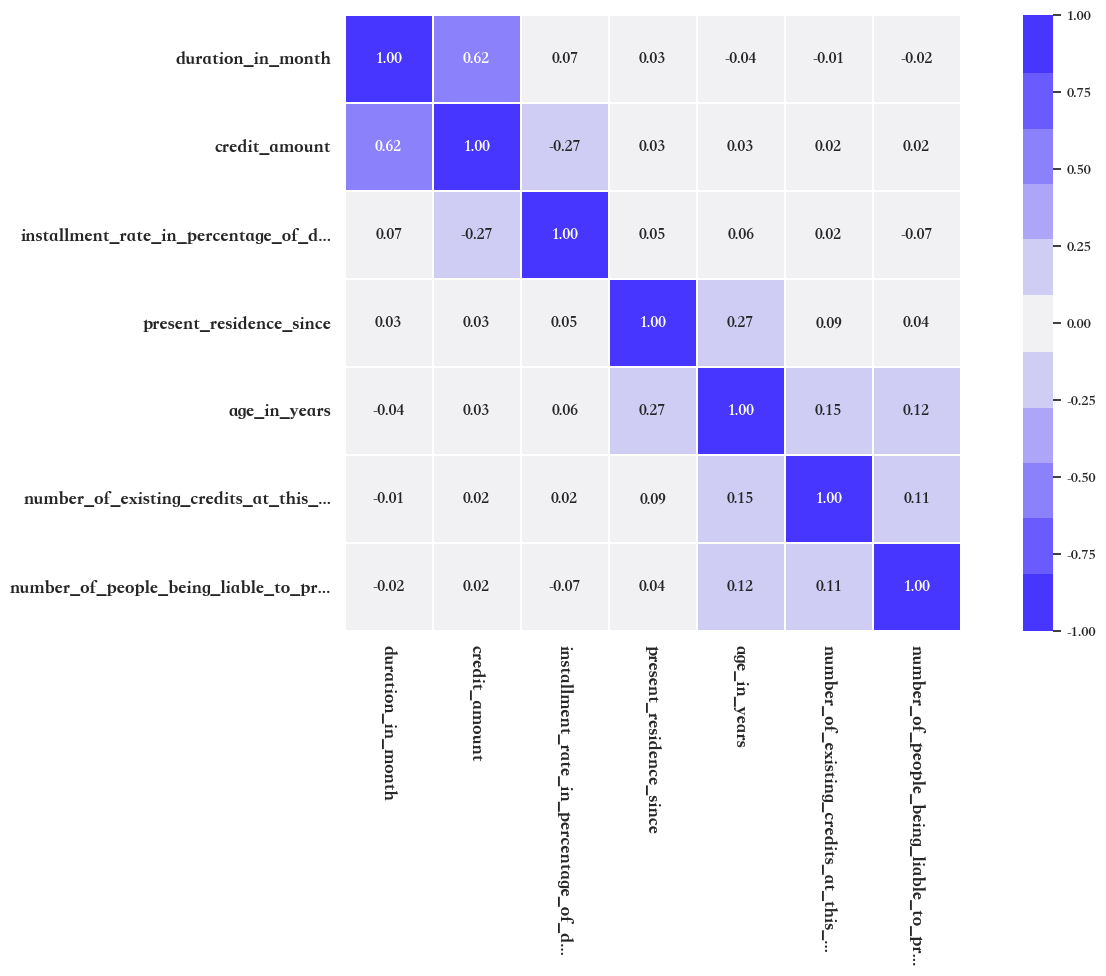

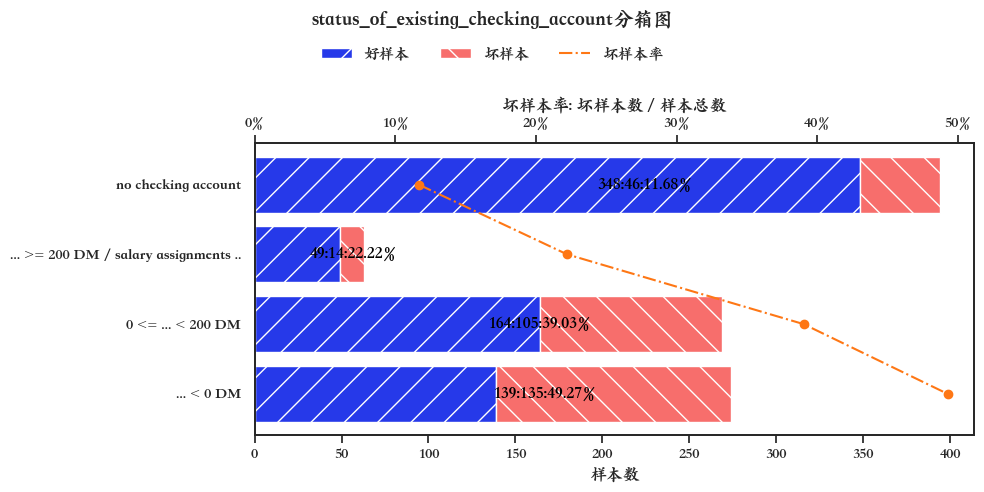

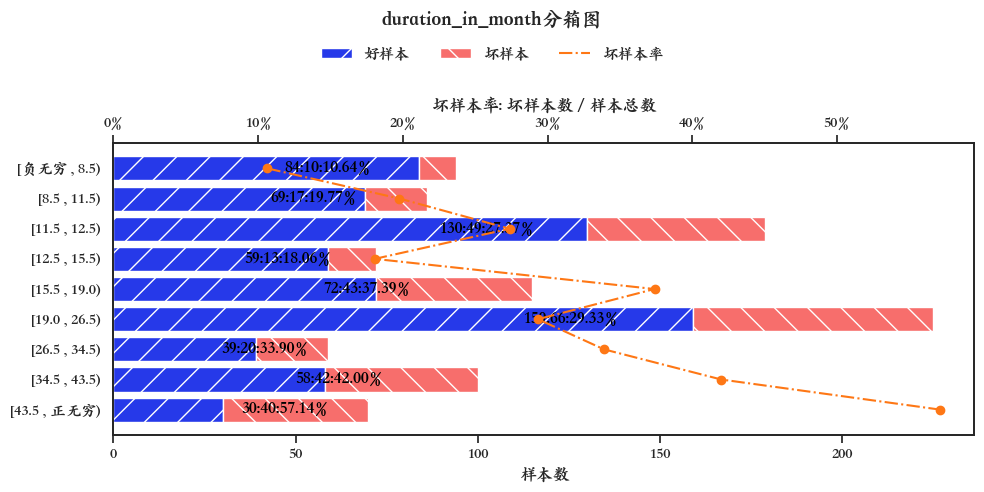

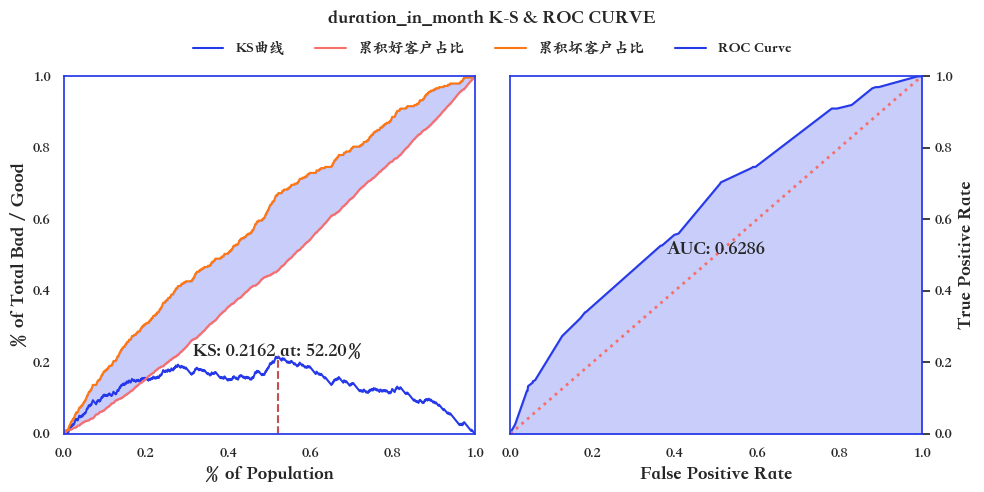

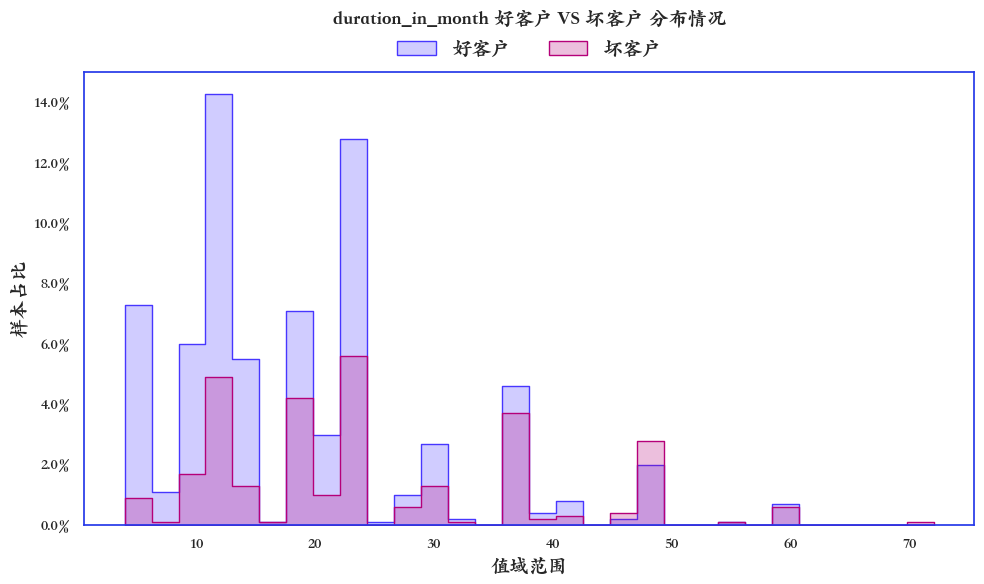

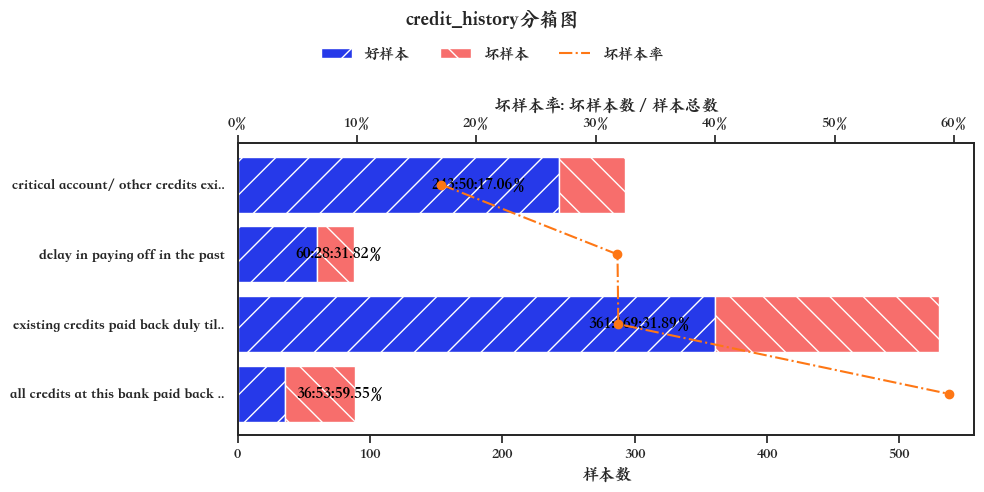

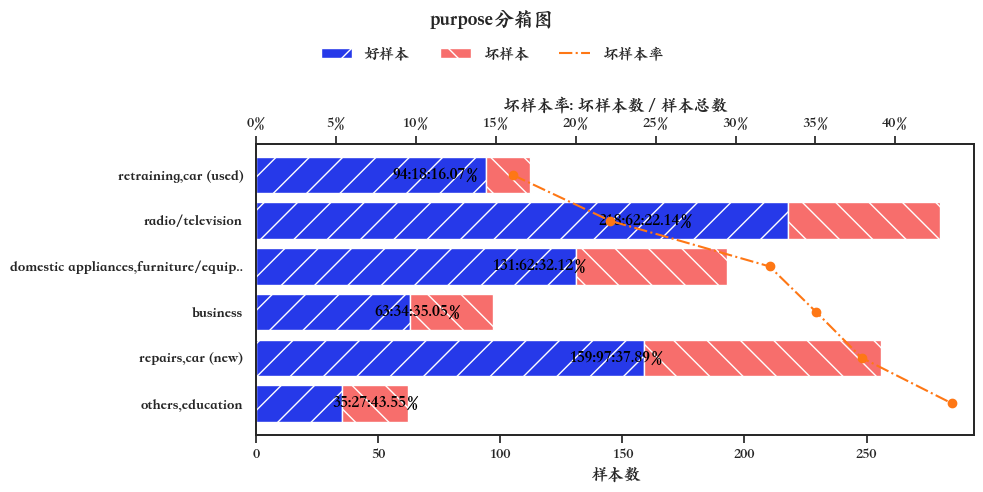

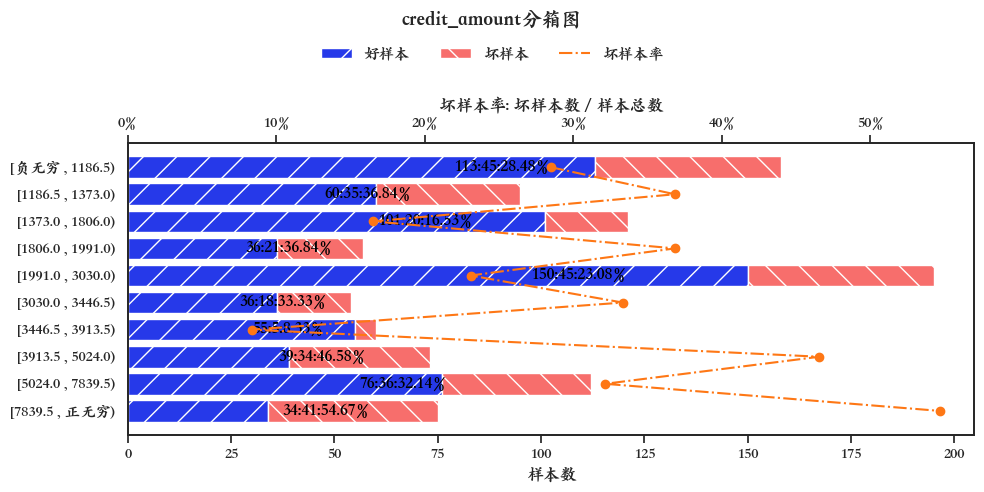

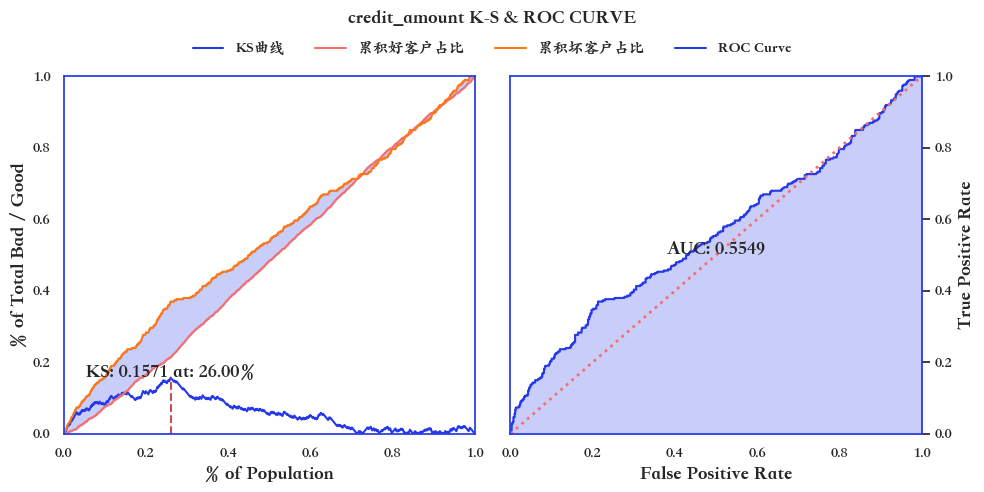

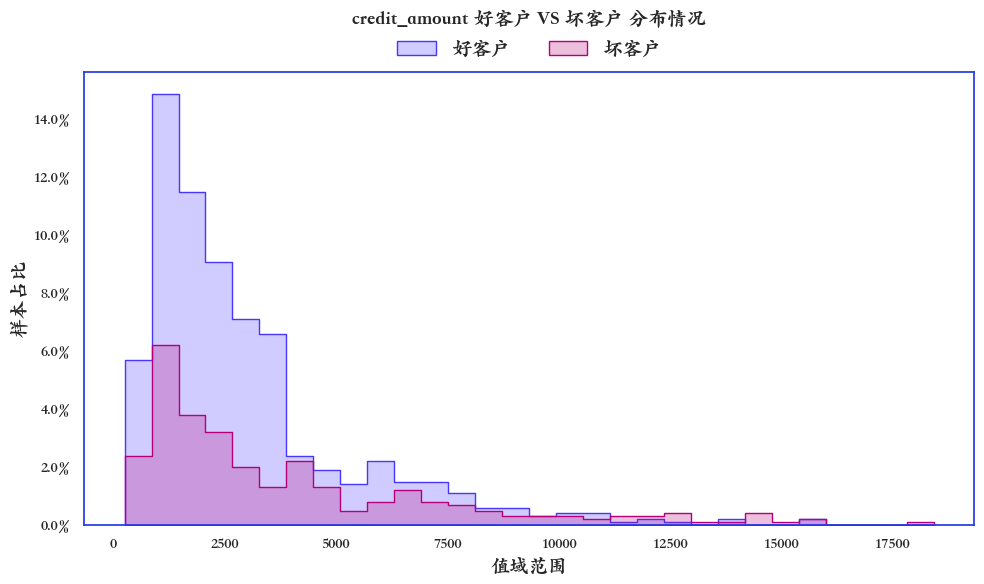

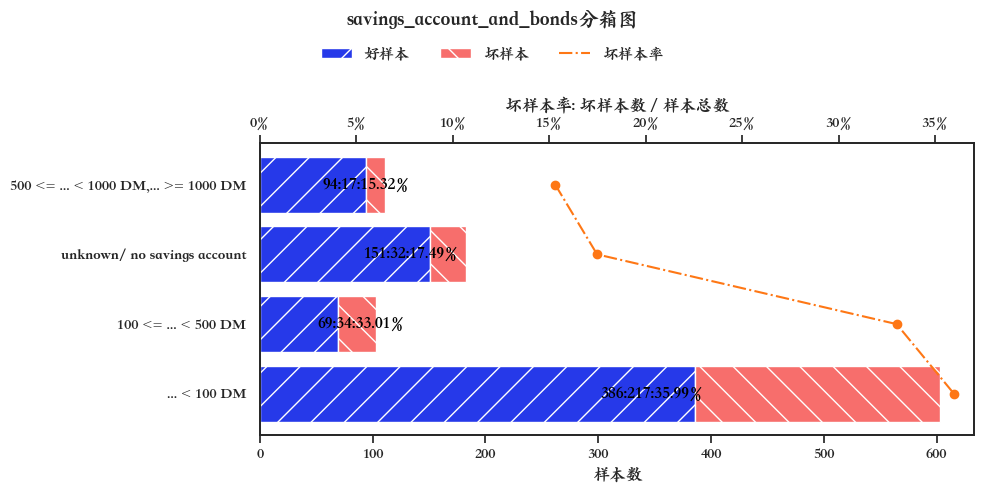

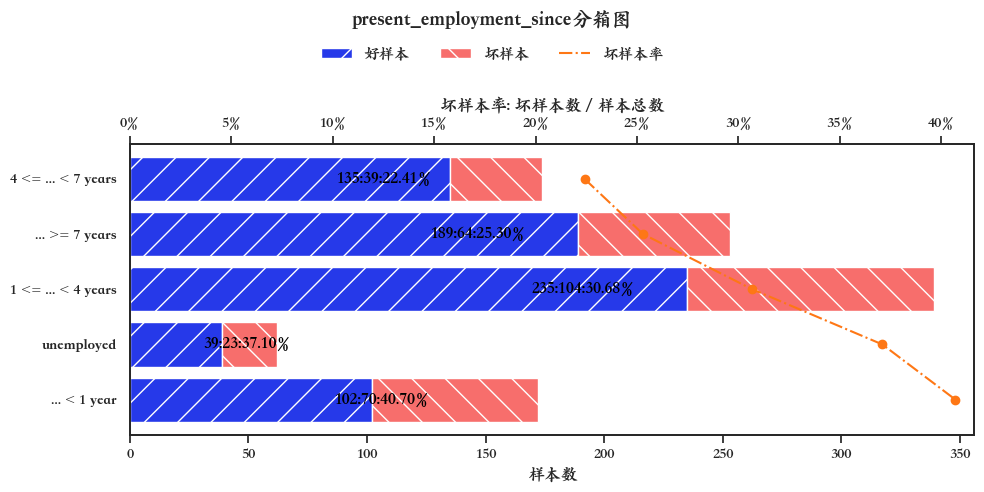

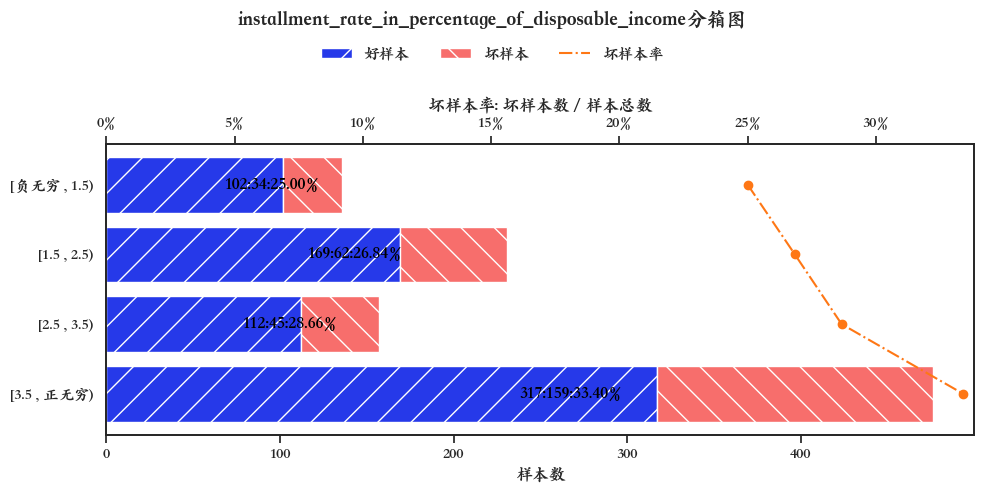

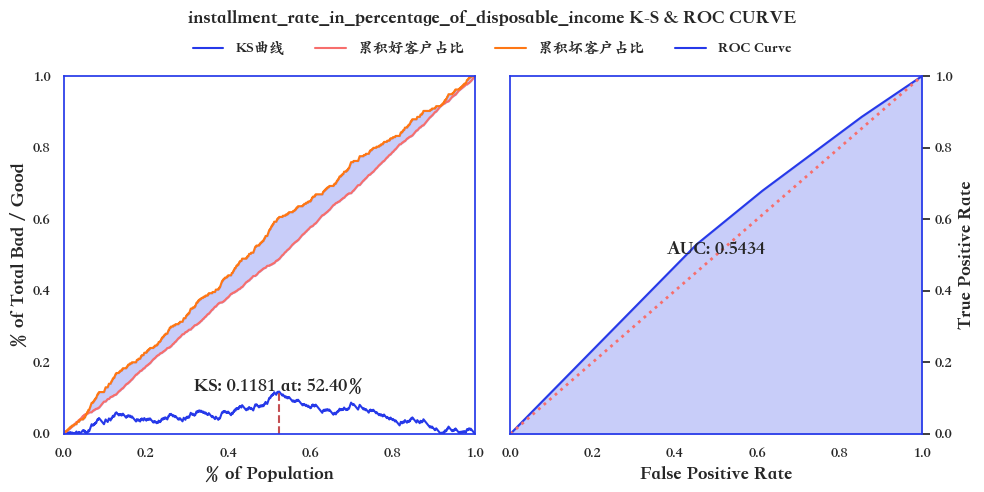

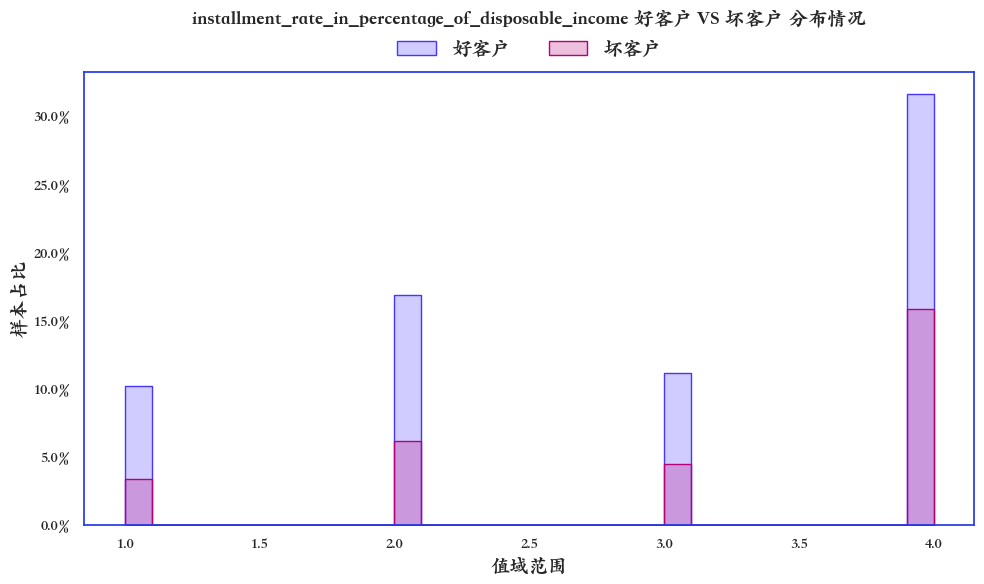

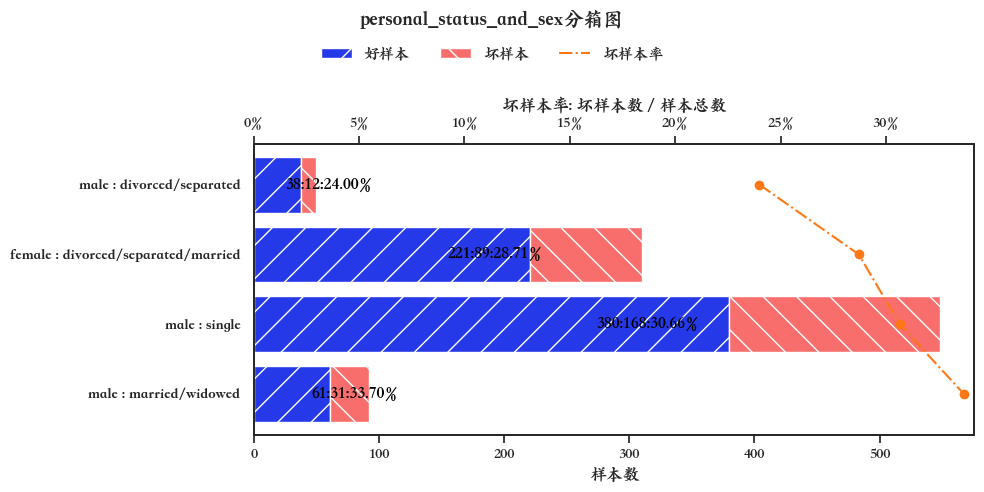

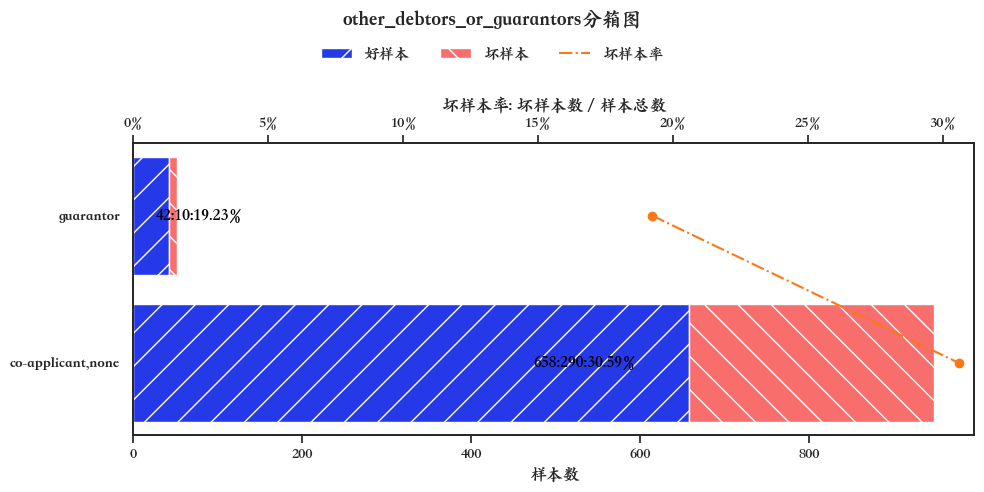

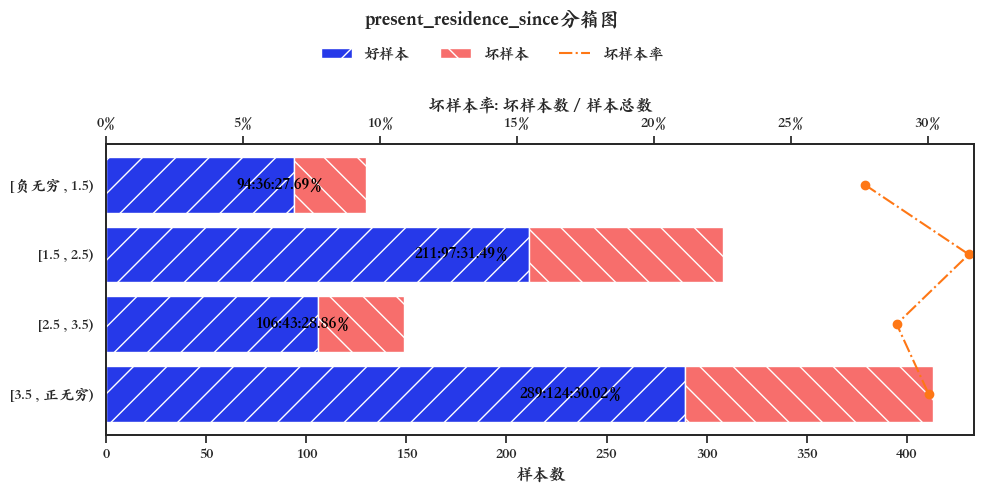

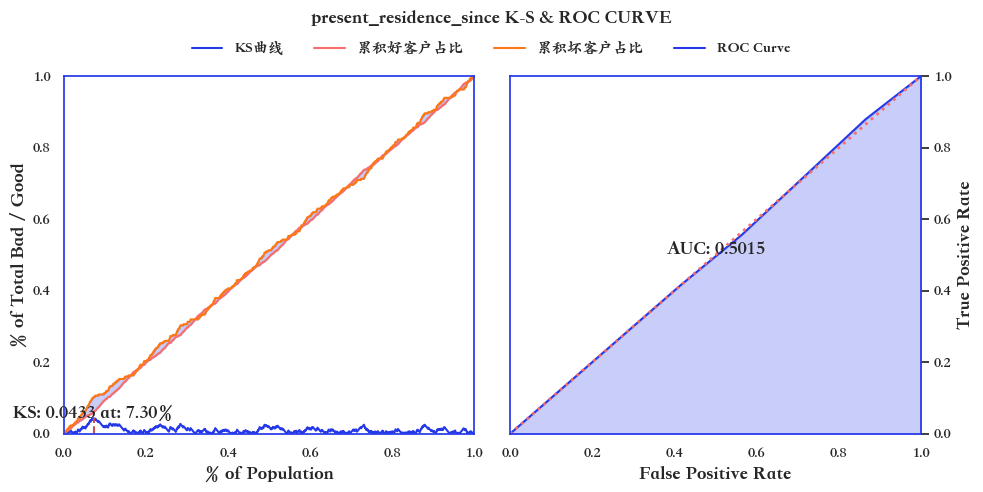

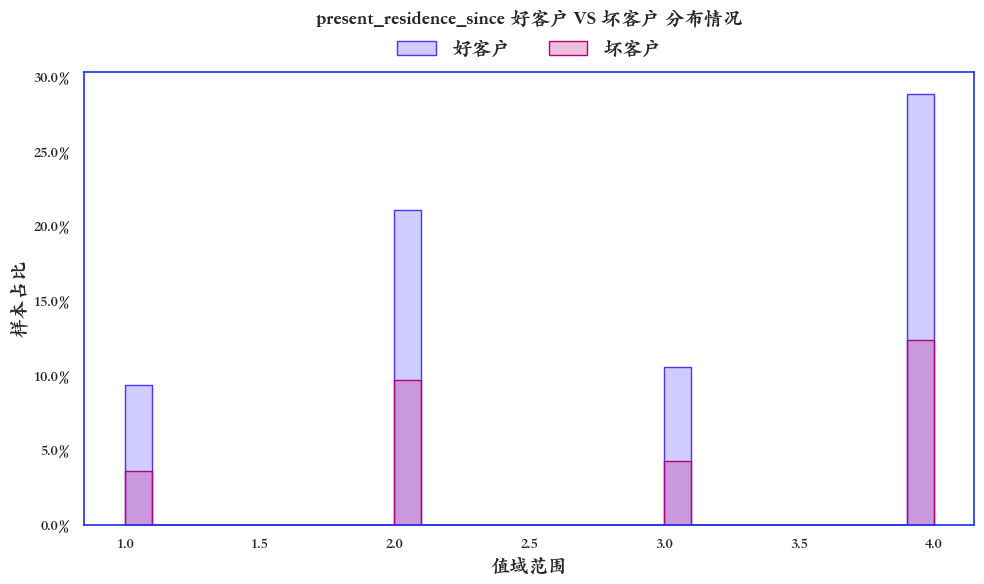

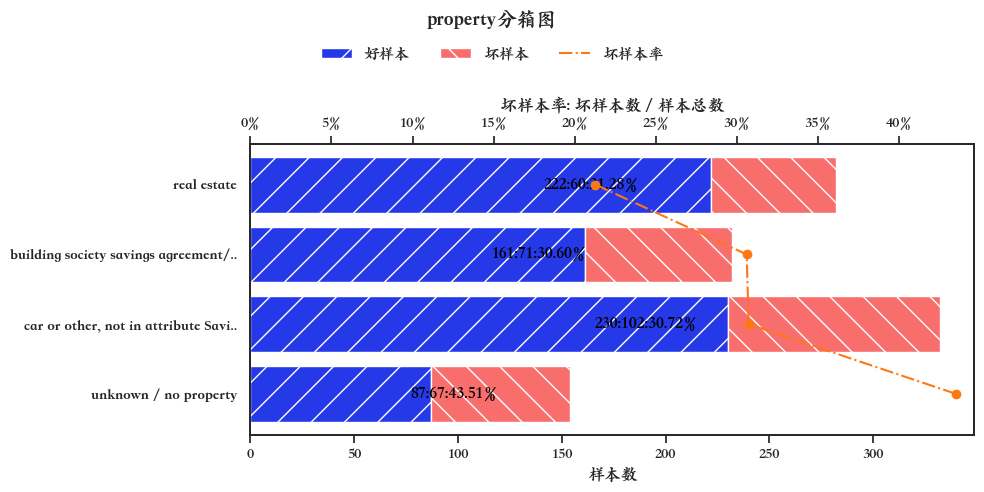

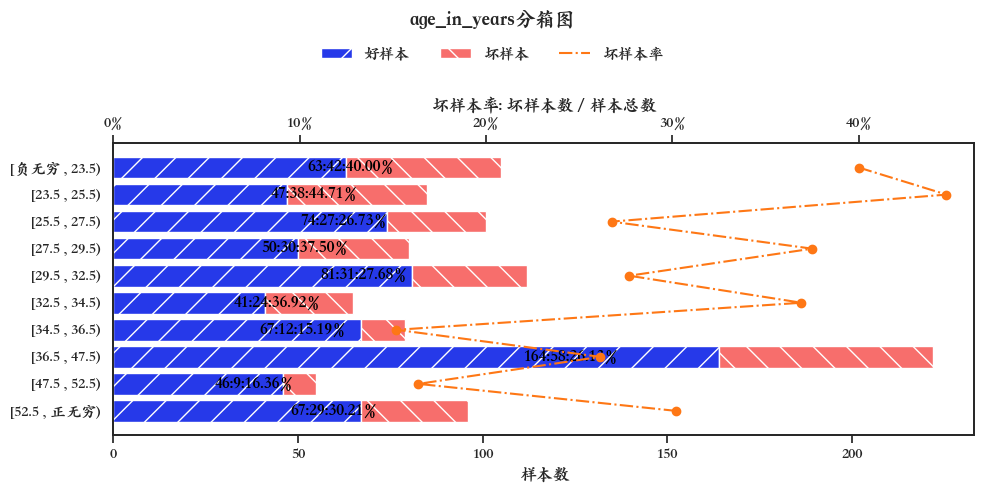

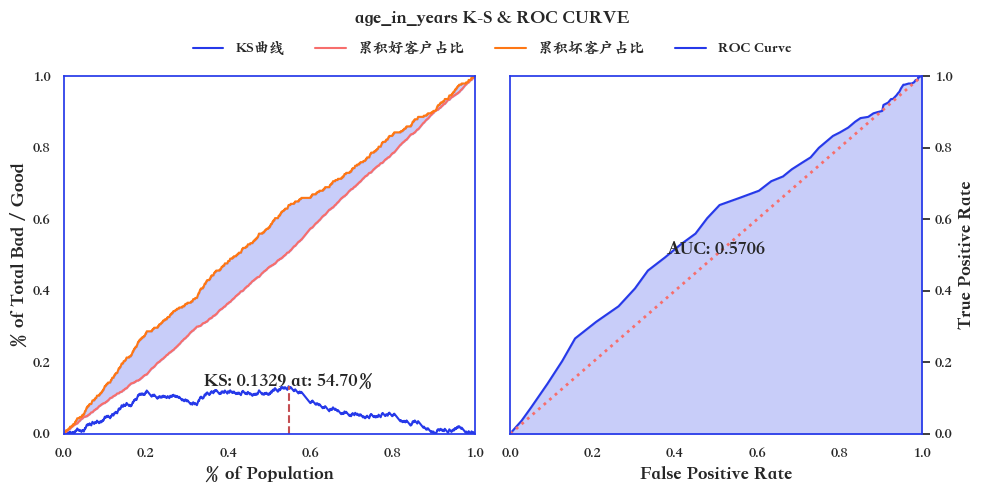

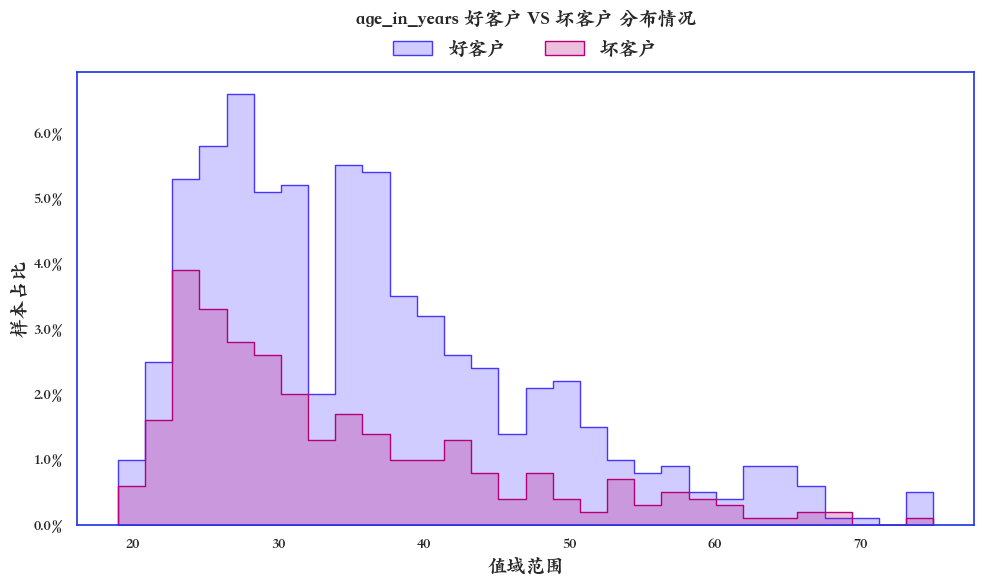

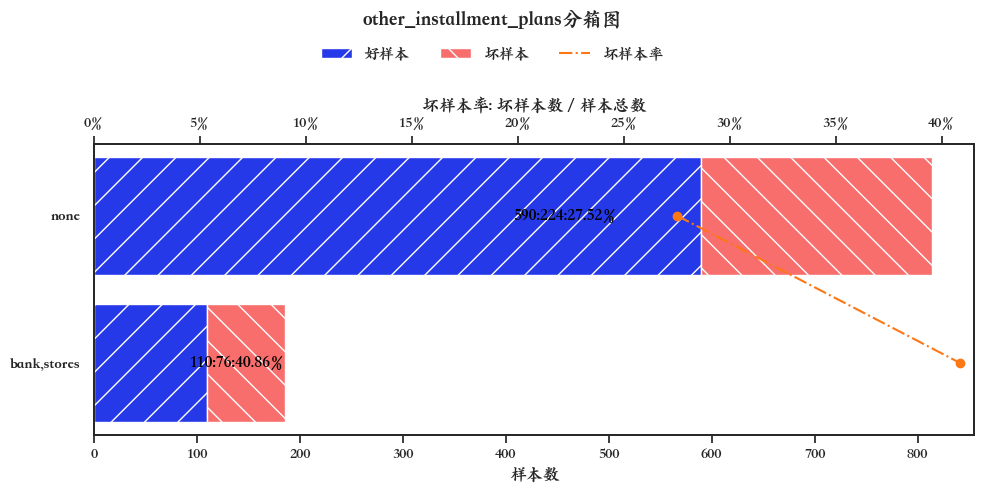

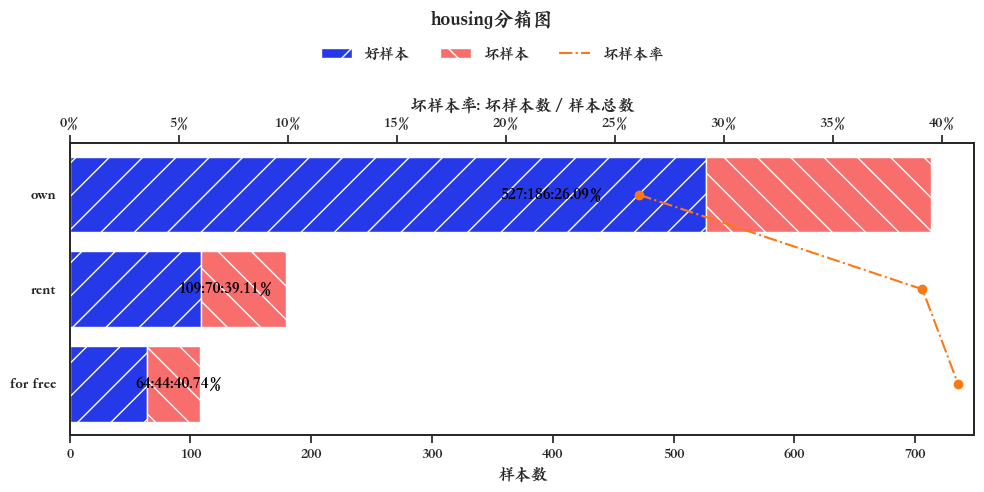

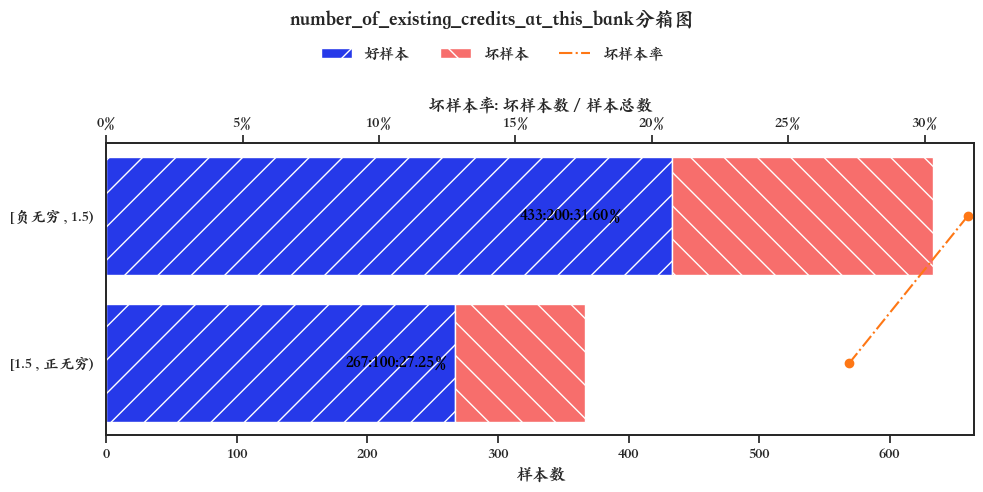

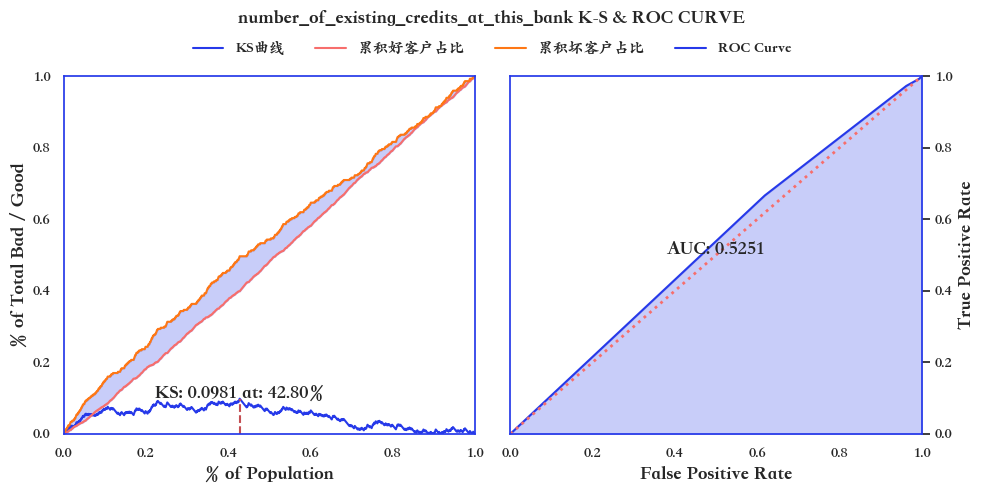

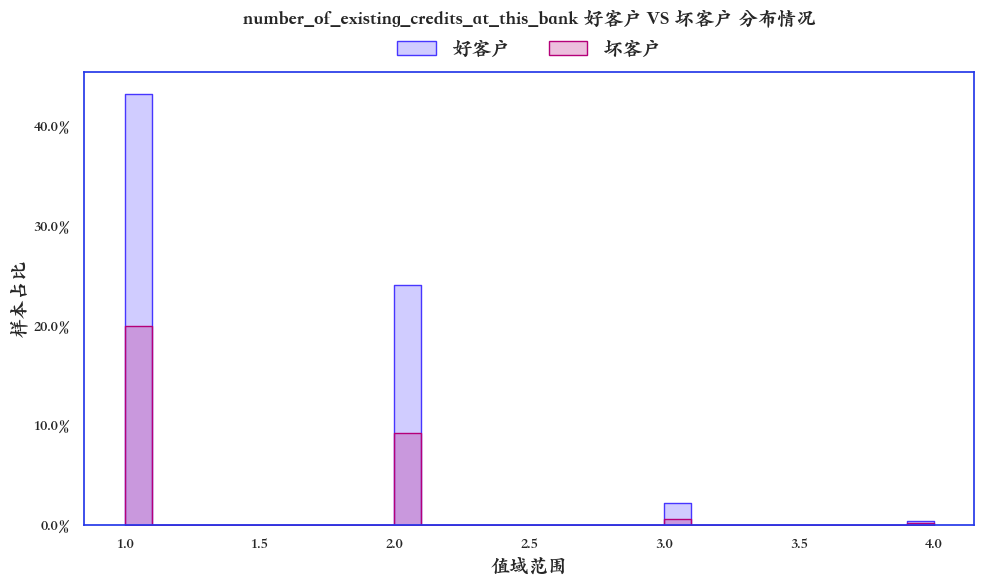

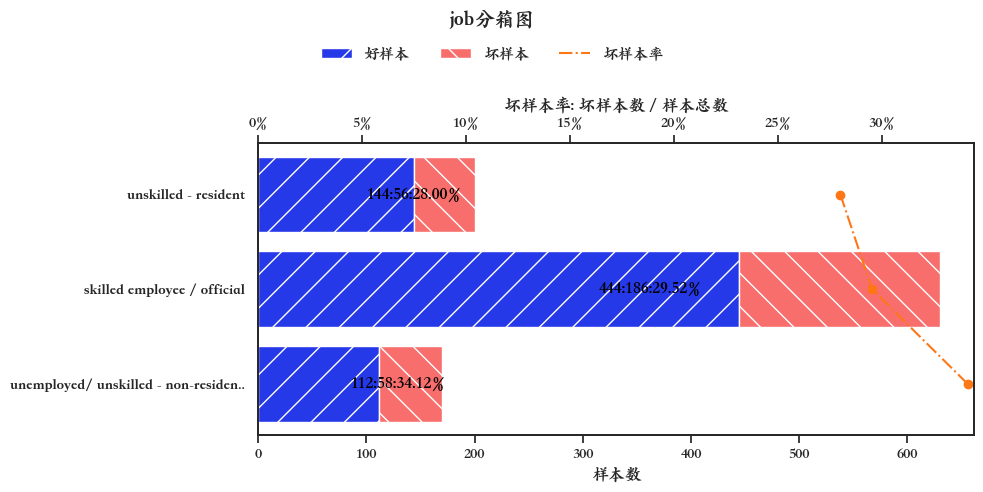

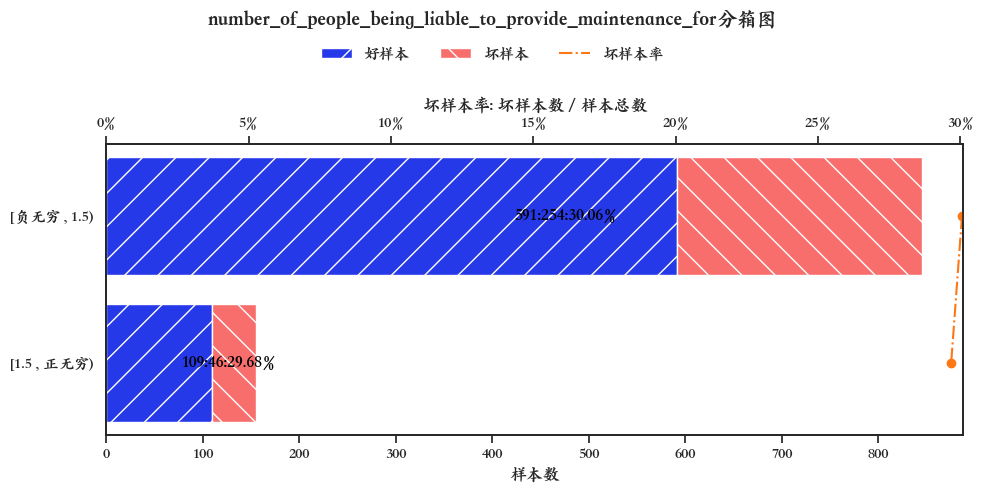

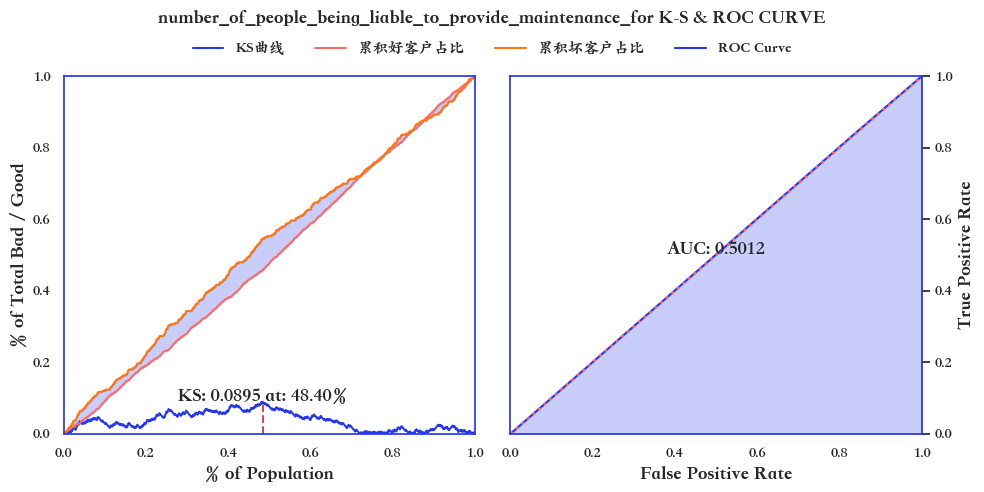

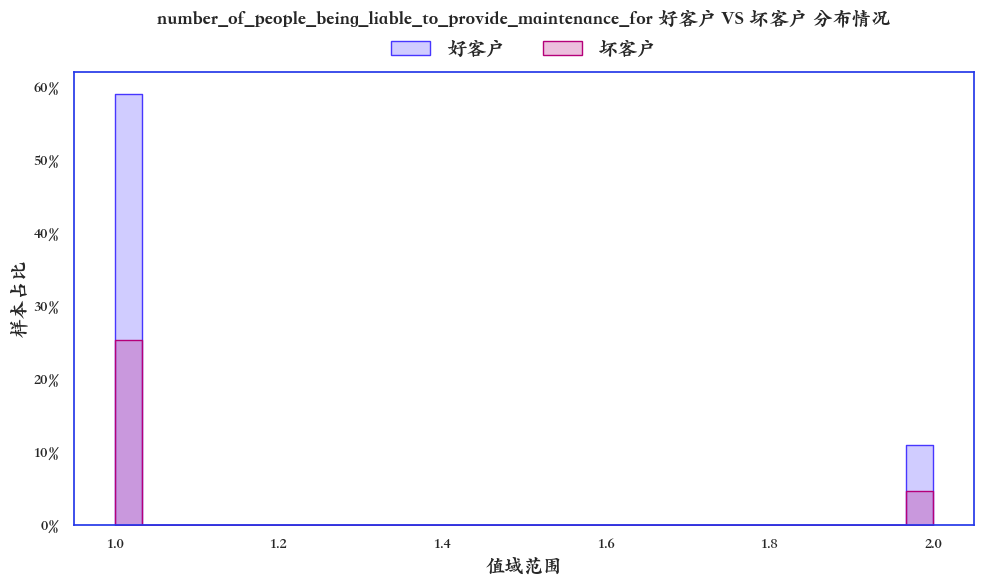

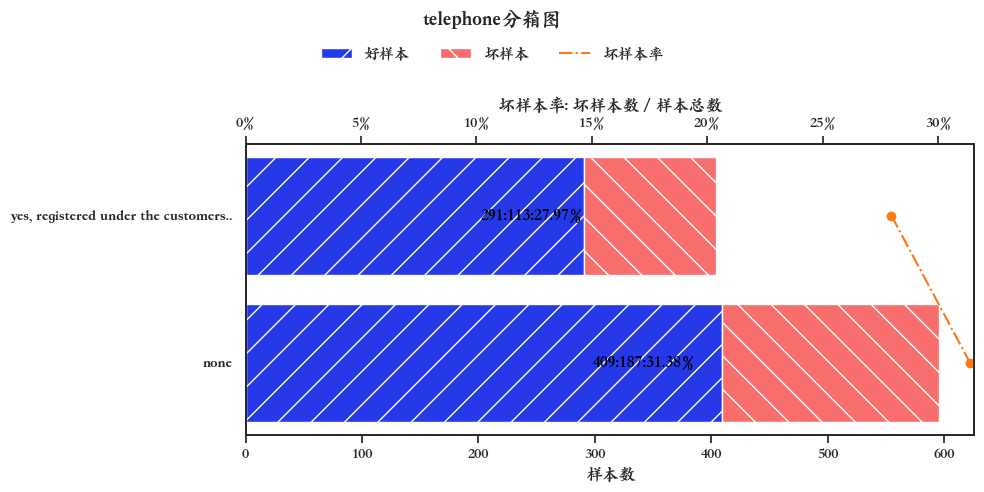

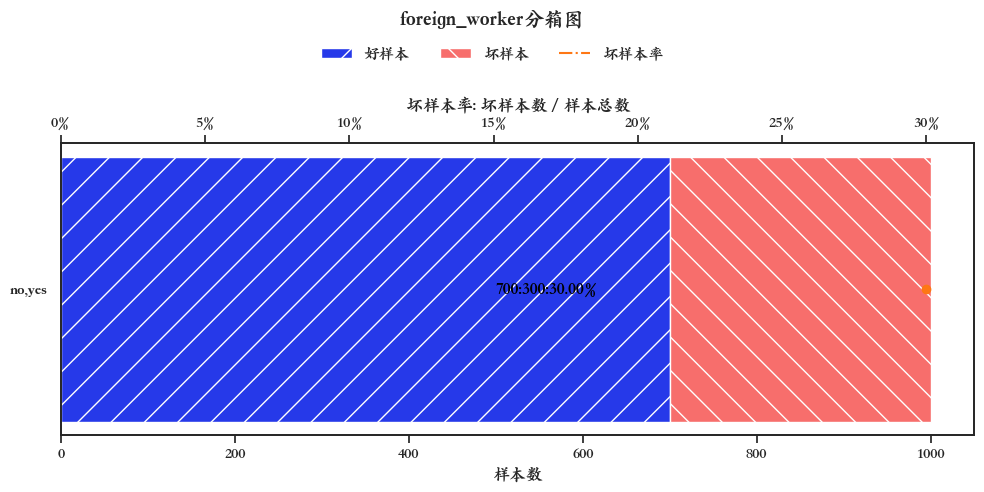

In [2]:
# 参考: https://scorecardpipeline.itlubber.art/scorecardpipeline.html#module-scorecardpipeline.auto_report
# pip install scorecardpipeline -i https://pypi.org/simple

from scorecardpipeline import *

# 初始化设置，包含忽略warning、画图字体、[随机种子、日志输出]
init_setting()

# 加载数据集，标签转换为 0 和 1
target = "creditability"
data = germancredit()
data[target] = data[target].map({"good": 0, "bad": 1})
features = data.columns.drop(target).tolist()

# 测试报告输出
auto_data_testing_report(data
                         , features=features
                         , target=target
                         , date=None # 传入日期列名，会按 freq 统计不同时间维度好坏样本的分布情况
                         , freq="M"
                         , data_summary_comment=""
                         , excel_writer="model_report/三方数据测试报告.xlsx"
                         , sheet="分析报告"
                         , start_col=2
                         , start_row=2
                         , writer_params={}
                         , bin_params={"method": "dt", "min_bin_size": 0.05, "max_n_bins": 10} # feature_bin_stats 函数的相关参数
                         , pictures=['bin', 'ks', 'hist'] # 类别型变量不支持 ks 和 hist
                         , corr=True
                         )

### 自动EDA输出报告

In [ ]:
# https://scorecardpipeline.itlubber.art/scorecardpipeline.html#module-scorecardpipeline.auto_eda
from scorecardpipeline import *

# 加载数据集
data = germancredit()

# 设置目标变量名称 & 映射目标变量值域为 {0, 1}
target = "creditability"
data[target] = data[target].map({"good": 0, "bad": 1})

# 自动 eda 并保存文件
auto_eda_sweetviz(data, target=target, save="model_report/auto_eda.html")

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:02 -> (00:00 left)                    

Report model_report/auto_eda.html was generated.


### 特征区分度

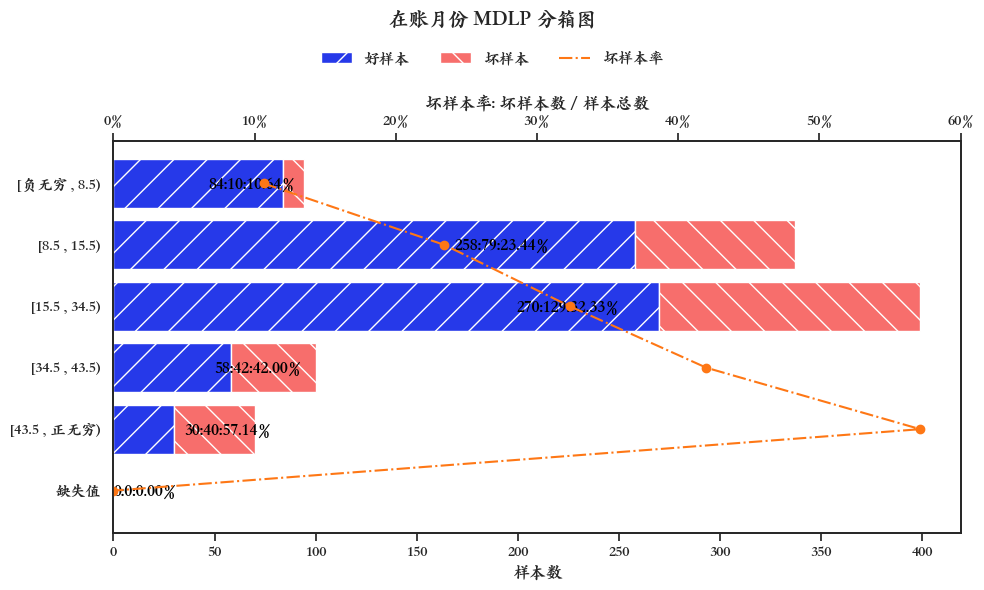

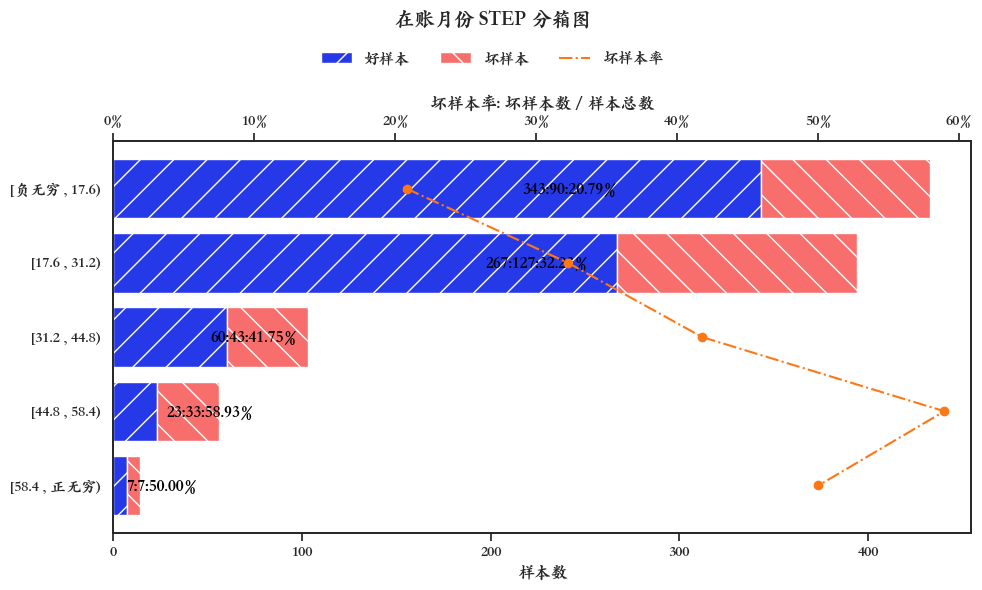

In [2]:
from scorecardpipeline import *

# 初始化配置
init_setting()

# 加载数据集
data = germancredit()

# 设置目标变量名称 & 映射目标变量值域为 {0, 1}
target = "creditability"
data[target] = data[target].map({"good": 0, "bad": 1})

use_cols = ['指标名称', '指标含义', '分箱', '样本总数', '样本占比', '好样本数', '好样本占比', '坏样本数', '坏样本占比', '坏样本率', '分档WOE值', '指标IV值', 'LIFT值', '坏账改善', '累积LIFT值', '累积坏账改善', '分档KS值']

# 使用 MDLP 自动分箱查看特征区分度
table_mdlp = feature_bin_stats(data, "duration_in_month", target=target, method="mdlp", desc="在账月份", max_n_bins=5)[use_cols]
bin_plot(table_mdlp, desc="在账月份 MDLP ", save="model_report/duration_in_month_mdlp_binplot.png")

# 使用 step 验证特征泛化能力
table_step = feature_bin_stats(data, "duration_in_month", target=target, method="step", desc="在账月份", max_n_bins=5)[use_cols]
bin_plot(table_step, desc="在账月份 STEP ", save="model_report/duration_in_month_step_binplot.png")

# 初始化 Excel 写入器
writer = ExcelWriter()

end_row, end_col = dataframe2excel(table_mdlp,
                                   writer,
                                   sheet_name="分箱信息",
                                   percent_cols=["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "坏账改善", "累积坏账改善"],
                                   condition_cols=["坏样本率", "LIFT值"],
                                   start_row=2,
                                   merge_column=["指标名称", "指标含义", "指标IV值"],
                                   merge=True,
                                   title="duration_in_month（在账月份） MDLP 特征区分度",
                                   figures=[f"model_report/duration_in_month_mdlp_binplot.png"])

end_row, end_col = dataframe2excel(table_step,
                                   writer,
                                   sheet_name="分箱信息",
                                   percent_cols=["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "坏账改善", "累积坏账改善"],
                                   condition_cols=["坏样本率", "LIFT值"],
                                   start_row=end_row + 2,
                                   merge_column=["指标名称", "指标含义", "指标IV值"],
                                   merge=True,
                                   title="duration_in_month（在账月份） STEP 特征区分度",
                                   figures=[f"model_report/duration_in_month_step_binplot.png"])

# 保存到 excel 文件
writer.save("model_report/数据有效性之特征区分度.xlsx")

In [5]:
# 随机生成逾期天数，模拟客户逾期数据
data["MOB1"] = np.where(np.random.random(len(data)) <= 0.8, 0, np.random.randint(1, 31, size=len(data)))

table = feature_bin_stats(data, "duration_in_month", overdue=["MOB1"], dpd=[0, 3], method="mdlp", max_n_bins=5, empty_separate=True, return_rules=False, del_grey=True, return_cols=['样本总数', '样本占比', '好样本数', '好样本占比', '坏样本数', '坏样本占比', '坏样本率', 'LIFT值', '累积LIFT值', '坏账改善', '累积坏账改善', '分档KS值'])

percent_cols = ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "坏账改善", "累积LIFT值", "累积坏账改善"]
condition_cols = ["坏样本率", "LIFT值"]

dataframe2excel(table
                , "model_report/数据有效性之特征区分度.xlsx"
                , percent_cols=[c for c in table.columns if (isinstance(c, tuple) and c[-1] in percent_cols) or (not isinstance(c, tuple) and c in percent_cols)]
                , condition_cols=[c for c in table.columns if (isinstance(c, tuple) and c[-1] in condition_cols) or (not isinstance(c, tuple) and c in condition_cols)]
                )

table

分箱详情                      MOB1 0+                                               ...  MOB1 3+                                                                  
                指标名称 指标含义             分箱     样本总数   样本占比     好样本数  好样本占比    坏样本数  坏样本占比   坏样本率  ...     好样本数  好样本占比    坏样本数  坏样本占比   坏样本率  LIFT值    坏账改善 累积LIFT值 累积坏账改善  分档KS值
0  duration_in_month        [负无穷 , 10.5) 171.0000 0.1710 131.0000 0.1609 40.0000 0.2151 0.2339  ... 131.0000 0.1609 36.0000 0.2081 0.2156 1.2299  0.0468  1.2299 0.0468 0.0472
1  duration_in_month       [10.5 , 19.0) 375.0000 0.3750 303.0000 0.3722 72.0000 0.3871 0.1920  ... 303.0000 0.3722 69.0000 0.3988 0.1855 1.0582  0.0352  1.1114 0.1340 0.0738
2  duration_in_month        [19.0 , 正无穷) 454.0000 0.4540 380.0000 0.4668 74.0000 0.3978 0.1630  ... 380.0000 0.4668 68.0000 0.3931 0.1518 0.8660 -0.1114  1.0000 0.0000 0.0000
3  duration_in_month                 缺失值   0.0000 0.0000   0.0000 0.0000  0.0000 0.0000 0.0000  ...   0.0000 0.0000  0.0000 0.0000 0.0000 0.0000  0.0000  0.0000 0.0000 0.0000

[4 rows x 27 columns]

### 模型增益效果评估

In [ ]:
# 选择需要评估的特征集
feature = ["duration_in_month"]

def calculate_model_score(data, target="target"):
    # 构建 pipeline
    model_pipeline = Pipeline([
        ("preprocessing", FeatureSelection(target=target, engine="toad")),
        ("combiner", Combiner(target=target, min_bin_size=0.1, max_n_bins=5, method="mdlp")),
        ("transform", WOETransformer(target=target)),
        ("processing_select", FeatureSelection(target=target, engine="toad")),
        ("stepwise", StepwiseSelection(target=target)),
        ("logistic", ITLubberLogisticRegression(target=target)),
    ])

    # 训练 pipeline
    model_pipeline.fit(data)

    # 计算模型指标
    return KS(model_pipeline.predict_proba(data)[:, -1], data[target])

# 计算模型指标增益效果
improvement = calculate_model_score(data, target=target) - calculate_model_score(data.drop(columns=feature), target=target)

print(f"特征: duration_in_month 在账月份 KS 增益效果 {improvement * 100:.4f}%")

特征: duration_in_month 在账月份 KS 增益效果 0.0952%


In [ ]:
table_mdlp

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,指标IV值,LIFT值,坏账改善,累积LIFT值,累积坏账改善,分档KS值
0,duration_in_month,在账月份,"[负无穷 , 8.5)",94.0000,0.0940,84.0000,0.1200,10.0000,0.0333,0.1064,1.2809,0.2839,0.3546,-0.0670,1.0000,0.0000,0.0000
1,duration_in_month,在账月份,"[8.5 , 15.5)",337.0000,0.3370,258.0000,0.3686,79.0000,0.2633,0.2344,0.3362,0.2839,0.7814,-0.1111,1.0670,0.6454,0.0867
2,duration_in_month,在账月份,"[15.5 , 34.5)",399.0000,0.3990,270.0000,0.3857,129.0000,0.4300,0.3233,-0.1087,0.2839,1.0777,0.0516,1.2361,0.3117,0.1919
3,duration_in_month,在账月份,"[34.5 , 43.5)",100.0000,0.1000,58.0000,0.0829,42.0000,0.1400,0.4200,-0.5245,0.2839,1.4000,0.0444,1.6078,0.1245,0.1476
4,duration_in_month,在账月份,"[43.5 , 正无穷)",70.0000,0.0700,30.0000,0.0429,40.0000,0.1333,0.5714,-1.1350,0.2839,1.9048,0.0681,1.9048,0.0681,0.0905
5,duration_in_month,在账月份,缺失值,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2839,0.0000,0.0000,0.0000,0.0000,0.0000


### 规则增益效果评估

In [45]:
from scorecardpipeline import *

# 初始化配置
init_setting()

# 加载数据集
data = germancredit()

# 设置目标变量名称 & 映射目标变量值域为 {0, 1}
target = "creditability"
data[target] = data[target].map({"good": 0, "bad": 1})

# 随机生成逾期天数，模拟客户逾期数据
data["MOB1"] = np.where(np.random.random(len(data)) <= 0.8, 0, np.random.randint(1, 31, size=len(data)))

In [46]:
rule = Rule("duration_in_month > 43.5")
rule.report(data[["duration_in_month", target]], target=target)

,规则分类,指标名称,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值,坏账改善,准确率,精确率,召回率,F1分数
0,验证规则,duration_in_month > 43.5,命中,70,0.0700,30,0.0429,40,0.1333,0.5714,1.9048,0.0681,0.7100,0.5714,0.1333,0.2162
1,验证规则,duration_in_month > 43.5,未命中,930,0.9300,670,0.9571,260,0.8667,0.2796,0.9319,-0.9048,0.2900,0.2796,0.8667,0.4228


In [65]:
rule = Rule("duration_in_month > 43.5")
rule.report(data[["duration_in_month", "MOB1"]], overdue=["MOB1"], dpd=[0, 3, 7, 15], filter_cols=['坏样本率', 'LIFT值', '坏账改善', '样本占比'], del_grey=False)

规则详情                                            MOB1 DPD0+                MOB1 DPD3+                MOB1 DPD7+                MOB1 DPD15+               
   规则分类                      指标名称   分箱 样本总数   样本占比       坏样本率  LIFT值    坏账改善       坏样本率  LIFT值    坏账改善       坏样本率  LIFT值    坏账改善        坏样本率  LIFT值    坏账改善
0  验证规则  duration_in_month > 43.5   命中   70 0.0700     0.1714 0.8282 -0.0129     0.1714 0.8791 -0.0091     0.1714 1.0025  0.0002      0.0857 0.7585 -0.0182
1  验证规则  duration_in_month > 43.5  未命中  930 0.9300     0.2097 1.0129  0.1718     0.1968 1.0091  0.1209     0.1710 0.9998 -0.0025      0.1151 1.0182  0.2415

In [47]:
prior_rules = Rule("credit_amount > 3972.25")
rule.report(data[["duration_in_month", "credit_amount", target]], target=target, prior_rules=prior_rules)

,规则分类,指标名称,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值,坏账改善,准确率,精确率,召回率,F1分数
0,先验规则,credit_amount > 3972.25,命中,250,0.2500,145,0.2071,105,0.3500,0.4200,1.4000,0.1333,0.6600,0.4200,0.3500,0.3818
1,先验规则,credit_amount > 3972.25,未命中,750,0.7500,555,0.7929,195,0.6500,0.2600,0.8667,-0.4000,0.3400,0.2600,0.6500,0.3714
0,验证规则,duration_in_month > 43.5,命中,11,0.0147,4,0.0072,7,0.0359,0.6364,2.4476,0.0215,0.7440,0.6364,0.0359,0.0680
1,验证规则,duration_in_month > 43.5,未命中,739,0.9853,551,0.9928,188,0.9641,0.2544,0.9785,-1.4476,0.2560,0.2544,0.9641,0.4026


In [69]:
pd.set_option('display.max_columns', None)

In [71]:
prior_rules = Rule("credit_amount > 3972.25")
rule = Rule("duration_in_month > 43.5")

rule.report(data[["duration_in_month", "credit_amount", "MOB1"]], overdue=["MOB1"], dpd=[0, 3, 7, 15], prior_rules=prior_rules, filter_cols=['坏样本数', '坏样本率', 'LIFT值', '坏账改善', '样本占比'], del_grey=True)

规则详情                                MOB1 DPD0+                            MOB1 DPD3+                            MOB1 DPD7+                            MOB1 DPD15+                           
   规则分类                      指标名称   分箱       样本占比 坏样本数   坏样本率  LIFT值    坏账改善       样本占比 坏样本数   坏样本率  LIFT值    坏账改善       样本占比 坏样本数   坏样本率  LIFT值    坏账改善        样本占比 坏样本数   坏样本率  LIFT值    坏账改善
0  先验规则   credit_amount > 3972.25   命中     0.2500   48 0.1920 0.9275 -0.0242     0.2500   45 0.1822 0.9231 -0.0256     0.2552   44 0.1789 1.0083  0.0029      0.2572   31 0.1330 1.0667  0.0231
1  先验规则   credit_amount > 3972.25  未命中     0.7500  159 0.2120 1.0242  0.0725     0.7500  150 0.2024 1.0256  0.0769     0.7448  127 0.1769 0.9971 -0.0083      0.7428   82 0.1218 0.9769 -0.0667
2  验证规则  duration_in_month > 43.5   命中     0.0147    2 0.1818 0.8576 -0.0021     0.0148    2 0.1818 0.8982 -0.0015     0.0153    2 0.1818 1.0279  0.0004      0.0149    1 0.1000 0.8207 -0.0027
3  验证规则  duration_in_month > 43.5  未命中     0.9853  157 0.2124 1.0021  0.1424     0.9852  148 0.2027 1.0015  0.1018     0.9847  125 0.1768 0.9996 -0.0279      0.9851   81 0.1222 1.0027  0.1793

In [ ]:
# all_data = load_pickle("/Users/lubberit/Desktop/workspace/scorecardpipeline/examples/all_data_qhyp.pkl")
# rule = Rule("(X1 < 588.5) & (X2 < 509.5)")
# prior_rule = Rule("放款金额 < 5000")
# all_data["target"] = (all_data["MOB1"] > 0).astype(int)
# table = rule.report(all_data[["X1", "X2", "放款金额", "MOB1", "target"]]
#                     , overdue=["MOB1"]
#                     , dpd=[0, 1, 2, 3, 4]
#                     , prior_rules=prior_rule
#                     # , filter_cols=['好样本数', '好样本占比', '坏样本数', '坏样本占比', '坏样本率', 'LIFT值', '坏账改善']
#                     )
# print(table)

# percent_cols = ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "坏账改善", "累积LIFT值", "累积坏账改善"]
# condition_cols = ["坏样本率", "LIFT值"]
# dataframe2excel(table, "规则有效性验证.xlsx", percent_cols=[c for c in table.columns if (isinstance(c, tuple) and c[-1] in percent_cols) or (not isinstance(c, tuple) and c in percent_cols)]
#                 , condition_cols=[c for c in table.columns if (isinstance(c, tuple) and c[-1] in condition_cols) or (not isinstance(c, tuple) and c in condition_cols)]
#                 )
